##### [< Forrige](10%20-%20statsmodels.ipynb)     |     [Neste >](12%20-%20animasjon%20med%20klasse.ipynb)

<span style="color:#9bb1d4;font-size:30px;font-weight:900"> 11 - interaktive websider </span>  

Vi husker fra sist hvordan vi importerte pakken "gapminder":

#### Eksempel 1:

In [1]:
import pandas as pd
g = pd.read_csv("https://titlon.uit.no/hht/data/gapminder.csv", index_col=0)#reading data
g

,country,year,population,continent,life_exp,gdp_cap
11,Afghanistan,2007,31889923,Asia,43.828,974.580338
23,Albania,2007,3600523,Europe,76.423,5937.029526
35,Algeria,2007,33333216,Africa,72.301,6223.367465
47,Angola,2007,12420476,Africa,42.731,4797.231267
59,Argentina,2007,40301927,Americas,75.320,12779.379640
...,...,...,...,...,...,...
1655,Vietnam,2007,85262356,Asia,74.249,2441.576404
1667,West Bank and Gaza,2007,4018332,Asia,73.422,3025.349798
1679,"Yemen, Rep.",2007,22211743,Asia,62.698,2280.769906
1691,Zambia,2007,11746035,Africa,42.384,1271.211593


Vi plottet så dataene, etter å ha konverter BNP til logartime:

#### Eksempel 2:

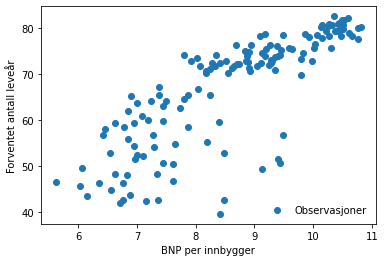

In [2]:
import numpy as np
from matplotlib import pyplot as plt

fig,ax=plt.subplots()

#adding axis lables:
ax.set_ylabel('Forventet antall leveår')
ax.set_xlabel('BNP per innbygger')

#plotting the function:
ax.scatter(np.log(g['gdp_cap']), g['life_exp'],  label='Observasjoner')
ax.legend(loc='lower right',frameon=False)

# Interaktiv graf

Vi ønsker imidlertid å lage en litt mer interessant fremstilling enn dette ved å 

1. Oversette navene på verdensdeler fra engelsk til norsk
2. Lage spesielle fargekoder for hver verdensdel
3. La størrelsen på prikkene indikere størrelse på land
3. Skape interaktivitet ved at det popper opp opplysningeer om navn, BNP, levealder og befolkning når man holder pekere over. 



## Databehandling
Det første vi må gjøre for å få til det er å lage en datasettet som inneholder de dataene vi trenger for å få til dette. Vi starter med å lage oppslag som definerer norske navn og fargekode. Disse brukes så med pandas `apply`-funksjon til å definere en kolonne `continent_no` med norske navn og en `colors`-kolonne:

#### Eksempel 3:

In [3]:
#creating a dictionary of continents with norwegian translation:
continents={'Africa': 'Afrika', 'Americas': 'Sør/Nord-Amerika', 'Asia': 'Asia', 'Europe': 'Europa', 'Oceania': 'Oseania'}
#assigning a color hex-code to each continent
colors={'Africa': '#E14827', 'Americas': '#84E127', 'Asia': '#2792E1', 'Europe': '#BC27E1', 'Oceania': '#E04A6C'}


g['continent_no']=g['continent'].apply(lambda cont:  continents[cont])
g['colors']=g['continent'].apply(lambda cont: colors[cont])
g

,country,year,population,continent,life_exp,gdp_cap,continent_no,colors
11,Afghanistan,2007,31889923,Asia,43.828,974.580338,Asia,#2792E1
23,Albania,2007,3600523,Europe,76.423,5937.029526,Europa,#BC27E1
35,Algeria,2007,33333216,Africa,72.301,6223.367465,Afrika,#E14827
47,Angola,2007,12420476,Africa,42.731,4797.231267,Afrika,#E14827
59,Argentina,2007,40301927,Americas,75.320,12779.379640,Sør/Nord-Amerika,#84E127
...,...,...,...,...,...,...,...,...
1655,Vietnam,2007,85262356,Asia,74.249,2441.576404,Asia,#2792E1
1667,West Bank and Gaza,2007,4018332,Asia,73.422,3025.349798,Asia,#2792E1
1679,"Yemen, Rep.",2007,22211743,Asia,62.698,2280.769906,Asia,#2792E1
1691,Zambia,2007,11746035,Africa,42.384,1271.211593,Afrika,#E14827


\#E14827 er for eksempel koden for en rødfarge.

Punkt 3. var at størrelsen på prikkene skal indikere land. Da trenger vi en kolonne som angir størrelse i pikser, som python forstår, i stedet for faktisk befolkning. Variasjonen i befolkning er også så stor at vi tar roten av den faktiske befolkningen for at det skal se penere ut. Formelen for størrelse på prikkene settes derfor til `pop**0.5/300`, der `pop`er befolkning i millioner.

#### Eksempel 4:

In [4]:
g['size']=g['population'].apply(lambda pop: pop**0.5/300)
display(g[g['country']=='India'])
g

,country,year,population,continent,life_exp,gdp_cap,continent_no,colors,size
707,India,2007,1110396331,Asia,64.698,2452.210407,Asia,#2792E1,111.075366


,country,year,population,continent,life_exp,gdp_cap,continent_no,colors,size
11,Afghanistan,2007,31889923,Asia,43.828,974.580338,Asia,#2792E1,18.823721
23,Albania,2007,3600523,Europe,76.423,5937.029526,Europa,#BC27E1,6.325015
35,Algeria,2007,33333216,Africa,72.301,6223.367465,Afrika,#E14827,19.244975
47,Angola,2007,12420476,Africa,42.731,4797.231267,Afrika,#E14827,11.747565
59,Argentina,2007,40301927,Americas,75.320,12779.379640,Sør/Nord-Amerika,#84E127,21.161266
...,...,...,...,...,...,...,...,...,...
1655,Vietnam,2007,85262356,Asia,74.249,2441.576404,Asia,#2792E1,30.779206
1667,West Bank and Gaza,2007,4018332,Asia,73.422,3025.349798,Asia,#2792E1,6.681926
1679,"Yemen, Rep.",2007,22211743,Asia,62.698,2280.769906,Asia,#2792E1,15.709779
1691,Zambia,2007,11746035,Africa,42.384,1271.211593,Afrika,#E14827,11.424163


Vi ser over at for India blir for eksempel størrelsen da 111 piksler. 

Til sist var målsettingen i punkt 4 å lage interaktivitet ved å få hvert datapunkt til å vise ytterligere informasjon når vi holder pekeren over. Vi starter med å definerer variablene som skal poppe opp. For å få norsk tusenskilletegn, med mellomrom, kan vi gjøre slik:

#### Eksempel 5:

In [5]:
'{:,}'.format(int(23153161365)).replace(',',' ')

'23 153 161 365'

Vi kan nå, med norsk tusenskilletegn, definere BNP i norske kroner (vekslingskurs 8.9NOK/USD), forventet livslengde og befolkning i millioner, i heltall. 

#### Eksempel 6:

In [6]:
g['gdp_capNOK']=g['gdp_cap'].apply(lambda gdp: '{:,}'.format(int(8.9*gdp)).replace(',',' '))
g['life_exp_rnd']=g['life_exp'].apply(lambda l: int(l))
g['pop_mill_str']=g['population'].apply(lambda pop:  '{:,}'.format(int(pop/1000000)))
g

,country,year,population,continent,life_exp,gdp_cap,continent_no,colors,size,gdp_capNOK,life_exp_rnd,pop_mill_str
11,Afghanistan,2007,31889923,Asia,43.828,974.580338,Asia,#2792E1,18.823721,8 673,43,31
23,Albania,2007,3600523,Europe,76.423,5937.029526,Europa,#BC27E1,6.325015,52 839,76,3
35,Algeria,2007,33333216,Africa,72.301,6223.367465,Afrika,#E14827,19.244975,55 387,72,33
47,Angola,2007,12420476,Africa,42.731,4797.231267,Afrika,#E14827,11.747565,42 695,42,12
59,Argentina,2007,40301927,Americas,75.320,12779.379640,Sør/Nord-Amerika,#84E127,21.161266,113 736,75,40
...,...,...,...,...,...,...,...,...,...,...,...,...
1655,Vietnam,2007,85262356,Asia,74.249,2441.576404,Asia,#2792E1,30.779206,21 730,74,85
1667,West Bank and Gaza,2007,4018332,Asia,73.422,3025.349798,Asia,#2792E1,6.681926,26 925,73,4
1679,"Yemen, Rep.",2007,22211743,Asia,62.698,2280.769906,Asia,#2792E1,15.709779,20 298,62,22
1691,Zambia,2007,11746035,Africa,42.384,1271.211593,Afrika,#E14827,11.424163,11 313,42,11


## bokeh

Vi skal bruke en pakke som heter `bokeh` til å lage en interaktiv figur og nettside, av datasettet vi nettopp laget ferdig. Vi starter med å definere figuren. I Eksempel 7 lager vi en figur ved å kalle på figurfunksjonen i bokeh. 

* De første fire argumentene definerer tittel og navn på aksene. 

* `x_axis_type = "log"` har samme effekt som å konvertere BNP til log i [10 - statsmodels](10%20-%20statsmodels.ipynb), men med den forskjell at det er benevningen på aksen og ikke selve variabelen som konverteres. 

* Så defineres at det at grafen skal ha verktøytips ("tooltips"). Det vil si at det popper opp en forklaring når vi holder musen over et område, som nevnt i punkt 4. . Denne funksjonaliteten defineres med argumentet `tools = "hoover"`.

* I det neste argumentet defineres hva som skal vises som tips. Pekeren skal åpne en boks med en liten liste med navn på land, BNP/Innbygger, forventet levealder og befolkning. Dette oppnås med argumentet `tooltips`. Hvert element i listen er en `tuple` med tekst som skal vises, og hilken kolonne dataene skal hentes fra. For eksempel betyr `("Land","@country")` at på den første linjen skal teksten "Land" vises, og informasjonen skal hentes fra kolonnen "country" i datasettet. 

* Til sist settes størrelsen på plottet


#### Eksempel 7:

In [7]:
from bokeh.plotting import figure

#creating figure:
p = figure(
        title = "Levealder og BNP per innbygger", 
        x_axis_label = 'BNP per innbygger (NOK)',
        y_axis_label = 'Forventet antall leveår',
    
        x_axis_type = "log",
    
        tools="hover", 
        tooltips = [
            ("Land","@country"),
            ("BNP/innbygger","@gdp_capNOK"),
            ("Forventet alder","@life_exp_rnd"),
            ("Befolkning","@pop_mill_str")
            ],
    
        plot_height = 580,
        plot_width = 980)

Vi kan nå definere hva slags plott vi skal ha. Vi skal ha et scatter-plott som i [10 - statsmodels](10%20-%20statsmodels.ipynb), men dette blir altså interaktivt. Vi bruker da funksjonen `scatter`. 

Det første som må angis i `scatter` er datasettet, som altså er `g` her. Så angis at vi skal ha `gdp_cap` langs x-aksen og `life_exp` langs y-aksen. 

Til sist angis størrelse, farge og hvilen kollonne som definerer fargeetikettnavn. Til sist angis at prikkene skal være 20% gjennomsiktig. 

#### Eksempel 8:

In [8]:
from bokeh.io import show, output_notebook
from bokeh.plotting import output_file

p.scatter(
    source=g,
    x= 'gdp_cap', 
    y= 'life_exp',
    
    size='size', 
    color= 'colors',
    legend_field='continent_no',
    alpha= 0.8
    )

#Creating the graph and saving as html
output_notebook()
output_file("BNP_levealder.html")
show(p)

Loading BokehJS ...

Du kan nå selv teste vertktøytipsfunksonen ved å holde pekeren en av sirklene i figuren. 

Som vi ser over kalles følgende tre funksjoner, etter å ha definert plottet: 
* `output_notebook()` gir beskjed om at grafen skal vises i jupyter
* `output_file("BNP_levealder.html")` angir at html-filen som skal lagres skal hete "BNP_levealder.html"
* `show(p)` genererer html-filen og visning

Om du ønsker å legge denne grafen inn i en annen webside kan du for eksempel bruke iframes. [Her er et eksmpel på hvordan du gjør det fra W3Schools](https://www.w3schools.com/tags/tag_iframe.asp)

## Forbedringspotensiale

Men det er grunn til ikke å være helt fornøyd med resultatet. For det første bør benvenelsen på x-aksen være mer lesevennlig. Vi endrer derfor denne fra vitenskapelig format til 1k, 10k og 100k, der k=1000. Etikettene ligger delvis over plottene, så vi flytter den til "top_left". I tillegg ser ikke linjene pene ut på en nettside, så vi fjerner de fleste av dem. Det kan vi gjøre med følgende kode:

#### Eksempel 9:

In [9]:
#formatting:
p.xaxis.major_label_overrides = { 1000: '1k', 10000: '10k', 100000: '100k' }
p.legend.location = "top_left"

p.legend[0].border_line_alpha=0
p.outline_line_alpha=0
p.grid[0].grid_line_alpha=0
p.grid[1].grid_line_alpha=0

output_notebook()
output_file("BNP_levealder.html")
show(p)

Loading BokehJS ...

# Interaktivt kart

Vi skal nå se hvordan vi kan lage interaktive kart med python. Vi skal se på ligningstall, stemmegivning og geografisk plassering i Tromsø kommune. Følgende kode laster datasettet:

#### Eksempel 10:

In [10]:
import pandas as pd

data=pd.read_csv(
    r"https://titlon.uit.no/hht/data/valgkretser/data.csv",
    encoding="latin-1",
    delimiter=";") 
data

,Bydel,Inntekt,Formue,Skatt,Alder,Skattepliktige,Andel med høyere utdanning,Rødhet,ApSVR,HFrp,Mynter,Lat,Lon
0,Bjerkaker,355 654,677 004,125 076,55,6 963,69.7,-0.200,0.448,0.248,8,69.642929,18.905919
1,Hamna,354 089,394 295,125 517,52,2 785,66.2,-0.208,0.431,0.223,1,69.708994,18.981154
2,Kaldfjord,300 249,469 818,101 027,57,3 581,51.4,0.095,0.255,0.350,3,69.675000,18.756800
3,Kattfjord,237 737,473 271,75 624,57,245,26.5,0.260,0.120,0.380,3,69.622966,18.307996
4,Kroken,277 682,369 369,92 059,60,4 206,43.8,-0.093,0.348,0.255,1,69.684100,19.072100
5,Kvaløysletta,338 632,504 744,117 810,55,4 869,61.0,-0.082,0.342,0.260,4,69.688400,18.856900
6,Lakselvbukt,240 095,614 059,69 575,66,647,22.5,-0.231,0.403,0.172,6,69.460350,19.729821
7,Malangshalvøya,251 949,479 646,80 005,61,231,NaN,-0.176,0.338,0.162,3,69.513294,18.749502
8,Mortensnes,320 395,543 649,109 871,57,3 211,76.2,-0.209,0.454,0.245,5,69.679948,18.922906
9,Ramfjord,252 236,459 362,76 676,63,1 066,32.3,0.214,0.142,0.356,3,69.561400,19.182000


Som vi ser, inneholder datasettet ligningstall fra 2015, utdanningsnivå og politisk opplsutning ved valget 2019. "Rødhet" er differansen på hvor mange som har stemt Arbeiderpartiet, Sosialistisk Venstreparti og Rødt. HFrp angir hvor mange som stemte på Høyre og Frp. "Mynter" er et tall som er proporsjonalt med gjennomsnittlig inntekt. Vi kommer tilbake til hva det skal brukes til. 

De siste to variabelene er Lat og Lon. De angir hvor på kartet vi skal sette markøren for hver bydel. Som su ser ligger alle plasseringene på [nesten 70 grader nord](https://jarleheitmann.no/index.php/2017/04/30/sanger-om-tromso/). 

## Kartdata

For å importere kartdata bruker vi en pakke som heter "geopandas". Den kan lese kartfiler. Det finnes ulike formater for kartfiler, og geopandas leser de fleste. I dette tilfellet bruker vi kartdata som ligger på nettadressen `https://titlon.uit.no/hht/data/valgkretser.zip`, som er fra Tromsø kommune. Disse dataene angir grensene for valgkretsene/bydelene i Tromsø. 

#### Eksempel 11:

In [11]:
import geopandas as gpd
#loading the geographical data
#and converting to a coordinate system that folium understands:
geodata = gpd.read_file(r"https://titlon.uit.no/hht/data/valgkretser.zip")
#Need to specify which cooridinate system to use
geodata=geodata.to_crs('epsg:4326') 
geodata

,DATO,VKRETS_VKR,KOMM,OPPHAV,OPPDATERIN,OBJTYPE,GEOMETRITY,VKRETS_V_1,geometry
0,0,0,5401,"abas, dek og ssb grunnkretser",2.018042e+11,Valgkrets,10,Malangshalvøya,"POLYGON ((18.47644 69.52988, 18.51169 69.53640..."
1,0,0,5401,"abas, dek og ssb grunnkretser",2.018042e+11,Valgkrets,10,Ringvassøy,"POLYGON ((18.63313 69.90560, 18.66172 69.92736..."
2,0,0,5401,"abas, dek og ssb grunnkretser",2.018042e+11,Valgkrets,10,Sommarøy,"POLYGON ((17.70497 69.69430, 17.95871 69.70466..."
3,0,0,5401,"abas, dek og ssb grunnkretser",2.018042e+11,Valgkrets,10,Hamna,"POLYGON ((19.03735 69.73702, 19.04254 69.72157..."
4,0,0,5401,"abas, dek og ssb grunnkretser",2.018042e+11,Valgkrets,10,Kattfjord,"POLYGON ((18.16256 69.71271, 18.18350 69.71413..."
5,0,0,5401,"abas, dek og ssb grunnkretser",2.018042e+11,Valgkrets,10,Kroken,"POLYGON ((19.11535 69.77302, 19.23057 69.78766..."
6,0,0,5401,"abas, dek og ssb grunnkretser",2.018042e+11,Valgkrets,10,Stakkevollan,"POLYGON ((19.04254 69.72157, 19.04927 69.70125..."
7,0,0,5401,"abas, dek og ssb grunnkretser",2.018042e+11,Valgkrets,10,Tromsdalen,"POLYGON ((18.96265 69.64267, 18.96535 69.64391..."
8,0,0,5401,"abas, dek og ssb grunnkretser",2.018042e+11,Valgkrets,10,Sentrum,"POLYGON ((18.89095 69.67118, 18.90664 69.67316..."
9,0,0,5401,"abas, dek og ssb grunnkretser",2.018042e+11,Valgkrets,10,Ramfjord,"POLYGON ((19.00396 69.60616, 19.01408 69.60478..."


Over ser vi hvordan et kartdatasett ser ut. De viktigste variablene her er "VKRETS_V_1" som angir navnet på bydelen og "geometry" som angir grensene til valgkretsen. Vi ser ikke all dataen som ligger i hver celle under "geometry", men i hver celle er det et "polygon" (flerkant") som angir en lang rekke punkter. Under vises de første 300 tegnene av Sentrum bydel. Vi ser at polygonet er en rekke kombinasjoner av lengde og breddegrad, som tilsammen tegner et området på et kart. 



#### Eksempel 12:

In [12]:
str(geodata['geometry'][geodata['VKRETS_V_1']=='Sentrum'].iloc[0])[0:300]

'POLYGON ((18.890950024735744 69.67118404610525, 18.90664435998999 69.67315806463783, 18.907176231551816 69.67320209862983, 18.908092423275942 69.67270656310629, 18.909310090560457 69.67231606022511, 18.910633390164364 69.6720629768652, 18.91304476693651 69.67190671639537, 18.917418391700156 69.67208'

Setningen `geodata=geodata.to_crs('epsg:4326')` sørger for at koordinatsystemet som tromsø kommune bruker, konverteres til det som brukes av `folium`, som er kartpakken vi skal benytte her. 

## Sammeslåing av dataene

For å kunne slå sammen kart-dataene med de skatte- og  valgdataene, må vi angi hvilken variabel som identifiserer bydelene i begge datasettene. Disse to variablene må ha samme navn, så vi endrer navn på 'VKRETS_V_1' i kartdataene til 'Bydel':

#### Eksempel 13:

In [13]:
geodata=geodata.rename(columns={'VKRETS_V_1':'Bydel'})

Vi kan nå slå sammen dataene. Kollonenene 'Bydel' i hvert datasett angir hvilke rader som skal slås sammen. Det er endel felter i geodataene som vi ikke trenger, så vil filterer til slutt ut de variablene vi vil ha med: 

#### Eksempel 14:

In [14]:
#merging the demographic data into the geodata:
geodata_merged=geodata.merge(data,on='Bydel')
#Keeping only the relevant fields

geodata_merged.keys()

geodata_merged=geodata_merged[['Bydel', 'geometry', 'Inntekt', 'Formue', 'Skatt',
       'Alder', 'Skattepliktige', 'Andel med høyere utdanning', 'Rødhet',
       'ApSVR', 'HFrp', 'Mynter', 'Lat', 'Lon','OBJTYPE',
       'GEOMETRITY']]
geodata_merged

,Bydel,geometry,Inntekt,Formue,Skatt,Alder,Skattepliktige,Andel med høyere utdanning,Rødhet,ApSVR,HFrp,Mynter,Lat,Lon,OBJTYPE,GEOMETRITY
0,Malangshalvøya,"POLYGON ((18.47644 69.52988, 18.51169 69.53640...",251 949,479 646,80 005,61,231,NaN,-0.176,0.338,0.162,3,69.513294,18.749502,Valgkrets,10
1,Ringvassøy,"POLYGON ((18.63313 69.90560, 18.66172 69.92736...",256 291,462 820,84 786,58,133,NaN,-0.065,0.230,0.165,3,69.887738,18.981047,Valgkrets,10
2,Sommarøy,"POLYGON ((17.70497 69.69430, 17.95871 69.70466...",262 471,499 655,79 266,65,430,26.5,0.288,0.166,0.454,4,69.620089,18.022543,Valgkrets,10
3,Hamna,"POLYGON ((19.03735 69.73702, 19.04254 69.72157...",354 089,394 295,125 517,52,2 785,66.2,-0.208,0.431,0.223,1,69.708994,18.981154,Valgkrets,10
4,Kattfjord,"POLYGON ((18.16256 69.71271, 18.18350 69.71413...",237 737,473 271,75 624,57,245,26.5,0.260,0.120,0.380,3,69.622966,18.307996,Valgkrets,10
5,Kroken,"POLYGON ((19.11535 69.77302, 19.23057 69.78766...",277 682,369 369,92 059,60,4 206,43.8,-0.093,0.348,0.255,1,69.684100,19.072100,Valgkrets,10
6,Stakkevollan,"POLYGON ((19.04254 69.72157, 19.04927 69.70125...",278 337,444 617,93 479,54,3 238,65.5,-0.247,0.434,0.187,2,69.694375,19.009411,Valgkrets,10
7,Tromsdalen,"POLYGON ((18.96265 69.64267, 18.96535 69.64391...",319 239,507 815,108 823,56,10 388,50.4,-0.122,0.388,0.266,4,69.632760,19.054253,Valgkrets,10
8,Sentrum,"POLYGON ((18.89095 69.67118, 18.90664 69.67316...",336 127,593 756,117 468,53,12 326,70.9,-0.290,0.483,0.193,6,69.660230,18.953578,Valgkrets,10
9,Ramfjord,"POLYGON ((19.00396 69.60616, 19.01408 69.60478...",252 236,459 362,76 676,63,1 066,32.3,0.214,0.142,0.356,3,69.561400,19.182000,Valgkrets,10


## Bakgrunnskart

Å lage en nettside med et kart, gjør vi ganske enkelt ved bruk av en pakke som heter `folium`. Den følgende koden lager en nettside med et interaktivt kart (du kan navigere i det) med senter [69.67, 18.98] og zoom 10. Nettsiden lagres som 'tromso.html' og siden skal åpnes i en ny fane, når du kjører koden under.

#### Eksempel 15:

In [15]:
import webbrowser
import folium

#Creating the map
tromso=folium.Map(location=[69.67, 18.98],zoom_start=10)

#Creating the html file
tromso.save('tromso.html')

#Open the html in new tab
webbrowser.open('tromso.html')

False

## Farging av bydeler som indikasjon på stemmegivning

Det som gjenstår nå, er å fylle kartet med innhold. Vi begynner med å bruke geodata-settet til å fargelegge bydelene etter politisk tilhørighet. Flere stemmer til Frp og Høyre skal gi en mer blå farge, og stemmer til SV, Ap og Rødt skal gi mer 

Vi har nå et kart, som vi nå skal fylle med informasjonen vi ordnet i forrige avsnitt. `webbrowser.open('tromso.html')` åpner html-filen i en ny fane. 

Følgende kode bruker funksjonen `Choropleth` til å legge et lag over eksisterende kart med kommunegrensene fra 

#### Eksempel 16:

In [16]:
f=folium.Choropleth(
    geo_data=geodata_merged,
    name="choropleth",
    columns=["Bydel", "Rødhet"],
    data=geodata_merged,
    key_on="feature.properties.Bydel",
    fill_color="RdBu",
    nan_fill_color='white',
    fill_opacity=0.5,
    legend_name="Valgresultat oppslutning H+Frp minus Ap+SV+Rødt"
).add_to(tromso)

folium.LayerControl().add_to(tromso)

#Saving a new html wtih colour overlay
tromso.save('tromso.html')

Om du laster inn websiden på nytt, vil du nå se at bydelene har fått farger etter stemmegivgning

## Vertøytips

Vi skal nå legge til markører for hver bydel, og et verktøytips til hver markør. Verktøytips (tooltip) er en liten tekstboks som dukker opp når vi holder pekere over markøren. Verktøytipset skal inneholde følgende informasjon:

* Navn på bydel
* Gjennomsnittlig inntekt
* Gjennomsnittlig alder
* Andel med høyere utdanning
* Prosent som har stemt Ap+SV+Rødt
* Prosent som har stemt H+FrP

Tallene må formateres for å se pene ut og være formatert som prosenttall i vertktøytipset, så vi ordner det først:

#### Eksempel 17:

In [17]:
#cleaning data
import math

geodata_merged['Andel med høyere utdanning%'] = geodata_merged['Andel med høyere utdanning'].apply(
    
    lambda x: f"{int(x)}%"
    if not math.isnan(x) else 'NA')

geodata_merged['ApSVR%'] = geodata_merged['ApSVR'].apply(
    
    lambda x: f"{int(x*100)}%"  
    if not math.isnan(x) else 'NA')

geodata_merged['HFrp%'] = geodata_merged['HFrp'].apply(
    
    lambda x:  f"{int(x*100)}%"  
    if not math.isnan(x) else 'NA')

geodata_merged[['Bydel', 'Andel med høyere utdanning%', 'ApSVR%', 'HFrp%']]

,Bydel,Andel med høyere utdanning%,ApSVR%,HFrp%
0,Malangshalvøya,NA,33%,16%
1,Ringvassøy,NA,23%,16%
2,Sommarøy,26%,16%,45%
3,Hamna,66%,43%,22%
4,Kattfjord,26%,12%,38%
5,Kroken,43%,34%,25%
6,Stakkevollan,65%,43%,18%
7,Tromsdalen,50%,38%,26%
8,Sentrum,70%,48%,19%
9,Ramfjord,32%,14%,35%


Vi itererer så gjennom alle bydelene, og legger til en markør som skal vise vertøytipset. 

Først i iterasjonen finner vi breddegraden ("Lat") og lengdegraden ("lon") i geodata_merged-tabellen. Så lager vi en tekst-streng i html-format, som har fem linjer med informasjon som vises når musa beveger seg over markøren.

Vi setter markøren i `folium`-pakken ved hjelp av `Marker`-klassen, der det første argumentet er koordinatene på kartet, det andre argumentet er verktøytipset, altså tekstrengen som ble laget. Tredje argument angir at markøren skal være rød. 

#### Eksempel 18:

In [18]:
for i,r in geodata_merged.iterrows():
    #obtaining coordinates:
    lat=float(r['Lat'])
    lon=float(r['Lon'])   

    #tooltips text:
    t=(f"<b>{r['Bydel']}</b><br>"
        f"Inntekt: {          r['Inntekt']                    }<br>"
        f"Alder: {            r['Alder']                      }<br>"
        f"Høyere utdanning: { r['Andel med høyere utdanning%'] }<br>"
        f"Ap+SV+Rødt: {       r['ApSVR%']                     }<br>"
        f"H+FrP: {            r['HFrp%']                       }")
    
    #setting the marker:
    folium.Marker(
        [lat,lon-0.01],
        tooltip=t,
        icon=folium.Icon(color='red')
    ).add_to(tromso)
    
    
#saving the map as a html file:
tromso.save('./tromso.html')

<img align="right" src="img/coins/6coins.png" style="padding:20px;"><img align="left" src="img/coins/7coins.png" style="padding:20px;"><img align="right" src="img/coins/8coins.png" style="padding:20px;">

Vi skal nå lage en stabel med mynter som skal representere gjennomsnittsinntekten  I mappen img/coins/ ligger det bilder av én til ti mynter stablet i høyden. Vi illustrerer inntekt ved å velge bilde etter antall mynter angitt i kollonnen 'Mynter' i datasettet. Dette er gjort i eksemplet under:



#### Eksempel 19:

In [19]:
for i,r in geodata_merged.iterrows():
    #obtaining coordinates:
    lat=float(r['Lat'])
    lon=float(r['Lon']) 
    
    #creating pin for wealth. The height of the stack of coins is determined by the 
    #   picture file f"./img/{int(r['Mynter'])}coins.png":
    icon=folium.features.CustomIcon(f"img/coins/{int(r['Mynter'])}coins.png")
    folium.Marker([lat,lon+0.01],tooltip=f"Formue:{r['Formue']}",icon=icon).add_to(tromso)
    
#saving the map as a html file:
tromso.save('./tromso.html')
webbrowser.open('tromso.html')

False

# Oppgaver

## Oppgave interaktiv graf:

Gjør som i [10 - statsmodels](10%20-%20statsmodels.ipynb), og beregn regressionskoefisientene på akkurat samme måte med `res=OLS(y,x).fit()`. Lag så en regressjonslinje på samme måte som i [10 - statsmodels](10%20-%20statsmodels.ipynb). Tips:

* Siden x_aksen er på log-form, må x verdiene i `linspace`-funksjonene være i nivå, og ikke log-konvertert. 
* Av samme grunn må det tas log av `x` i definisjonen av `regression_line`
* i bokeh bruker du funksjonen `line` i stedet for `plot` for å lage en linje, og funksjonen anvendes på figur-objektet du har skapt, i stedet for `ax`-objektet. 

## Oppgave interaktivt kart:
* Bytt ut fargekode etter politisk parti til fargegode etter alder
* Legg til skatt i verktøytipset


##### [< Forrige](10%20-%20statsmodels.ipynb)     |     [Neste >](12%20-%20animasjon%20med%20klasse.ipynb)